## Assignment 4
#### Negin Baghbanzadeh

This assignment is based on content discussed in module 8 and using Decision Trees and Ensemble Models in classification and regression problems.

## Learning outcomes 

- Understand how to use decision trees on a Dataset to make a prediction
- Learning hyper-parameters tuning for decision trees by using RandomGrid 
- Learning the effectiveness of ensemble algorithms (Random Forest, Adaboost, Extra trees classifier, Gradient Boosted Tree)

In the first part of this assignment, you will use Classification Trees for predicting if a user has a default payment option active or not. You can find the necessary data for performing this assignment [here](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) 

This dataset is aimed at the case of customer default payments in Taiwan. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel Sorting Smoothing Method to estimate the real probability of default.

Required imports for this project are given below. Make sure you have all libraries required for this project installed. You may use conda or pip based on your set up.

__NOTE:__ Since data is in Excel format you need to install `xlrd` in order to read the excel file inside your pandas dataframe. You can run `pip install xlrd` to install 

In [1]:
import numpy as np
import pandas as pd

After installing the necessary libraries, proceed to download the data. Since reading the excel file won't create headers by default, we added two more operations to substitute the columns.

In [2]:
main_dataset = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls")
main_dataset.columns = main_dataset.iloc[0]
main_dataset.drop(['ID'], axis=1, inplace=True)

In [3]:
main_dataset.drop([0], axis=0, inplace=True)

In the following, you can take a look into the dataset.

In [4]:
main_dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
dataset = main_dataset.copy()

## Questions (15 points total)

#### Question 1 (2 pts)
Build a classifier by using decision tree and calculate the confusion matrix. Try different hyper-parameters (at least two) and discuss the result.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [7]:
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from IPython.display import SVG
from graphviz import Source
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [8]:
from prettytable import PrettyTable
from tabulate import tabulate

### Cleaning data

In [9]:
columns_categorical = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [10]:
pays = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
dataset[pays] = dataset[pays].replace(-2.0, np.nan)

In [11]:
dataset["MARRIAGE"].replace(0, 3, inplace=True)

In [12]:
dataset["EDUCATION"].replace(5, 4, inplace=True)
dataset["EDUCATION"].replace(6, 4, inplace=True)

In [13]:
dataset.dropna(inplace=True)

In [14]:
target_column = "default payment next month"
y = dataset[target_column]
y=y.astype('int')
X = dataset[[col for col in dataset.columns if col != target_column]]

### Train Test Split

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10086, stratify=y) #stratified sampling based on the target
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (17579, 23)
X_test.shape: (5860, 23)
y_train.shape: (17579,)
y_test.shape: (5860,)


In [16]:
def check_data_balance(series, style="seaborn-pastel"):
    with plt.style.context(style):
        unique = series.value_counts()
        display(unique) #show unique value counts of the target
        plt.pie(unique, explode=[0.05]*len(unique), labels=unique.index, autopct='%1.1f%%');

0    13540
1     4039
Name: default payment next month, dtype: int64

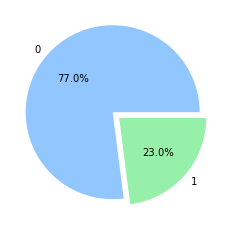

In [17]:
check_data_balance(y_train)

0    4514
1    1346
Name: default payment next month, dtype: int64

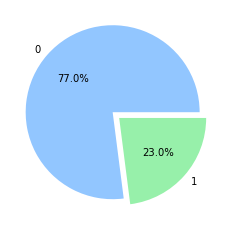

In [18]:
check_data_balance(y_test)

As you can see, our dataset is **imbalanced**. So metrics such as **ROC-AUC** or **F11-score** should be used and accuracy can't give us valid imformation about whether our model is having good results or not.

### Pipelines

In [19]:
pipeline_categorical = Pipeline([
('onehot', OneHotEncoder(handle_unknown="ignore")),
])

In [20]:
pipeline_full = ColumnTransformer([
("categorical", pipeline_categorical, columns_categorical),
])

Pipeline is only fitted on train data. Then both train and test data are transformed.

In [21]:
pipeline_full.fit(X_train)
X_train_transformed = pipeline_full.transform(X_train)
X_test_transformed = pipeline_full.transform(X_test)
print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_test_transformed.shape: {X_test_transformed.shape}")

X_train_transformed.shape: (17579, 68)
X_test_transformed.shape: (5860, 68)


### Tree Classifier

**First Decision Tree**

In [22]:
tree_clf_1 = DecisionTreeClassifier(max_depth=2, criterion='entropy', splitter='best')
tree_clf_1.fit(X_train_transformed, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

In [23]:
tree_clf_1_predictions = tree_clf_1.predict(X_test_transformed)
tree_clf_1_roc_auc = roc_auc_score(y_test, tree_clf_1_predictions)
tree_clf_1_f1 = f1_score(y_test, tree_clf_1_predictions)
tree_clf_1_accuracy = accuracy_score(y_test, tree_clf_1_predictions)
tree_clf_1_confusion_matrix = confusion_matrix(y_test, tree_clf_1_predictions)

**Second Decision Tree**

In [24]:
tree_clf_2 = DecisionTreeClassifier(max_depth=10, criterion='entropy', splitter='random')
tree_clf_2.fit(X_train_transformed, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, splitter='random')

In [25]:
tree_clf_2_predictions = tree_clf_2.predict(X_test_transformed)
tree_clf_2_roc_auc = roc_auc_score(y_test, tree_clf_2_predictions)
tree_clf_2_f1 = f1_score(y_test, tree_clf_2_predictions)
tree_clf_2_accuracy = accuracy_score(y_test, tree_clf_2_predictions)
tree_clf_2_confusion_matrix = confusion_matrix(y_test, tree_clf_2_predictions)

**Third Decision Tree**

In [26]:
tree_clf_3 = DecisionTreeClassifier(max_depth=20, criterion='gini', splitter='random')
tree_clf_3.fit(X_train_transformed, y_train)

DecisionTreeClassifier(max_depth=20, splitter='random')

In [27]:
tree_clf_3_predictions = tree_clf_3.predict(X_test_transformed)
tree_clf_3_roc_auc = roc_auc_score(y_test, tree_clf_3_predictions)
tree_clf_3_f1 = f1_score(y_test, tree_clf_3_predictions)
tree_clf_3_accuracy = accuracy_score(y_test, tree_clf_3_predictions)
tree_clf_3_confusion_matrix = confusion_matrix(y_test, tree_clf_3_predictions)

**Fourth Decision Tree**

In [28]:
tree_clf_4 = DecisionTreeClassifier(max_depth=10, criterion='gini', splitter='best')
tree_clf_4.fit(X_train_transformed, y_train)

DecisionTreeClassifier(max_depth=10)

In [29]:
tree_clf_4_predictions = tree_clf_4.predict(X_test_transformed)
tree_clf_4_roc_auc = roc_auc_score(y_test, tree_clf_4_predictions)
tree_clf_4_f1 = f1_score(y_test, tree_clf_4_predictions)
tree_clf_4_accuracy = accuracy_score(y_test, tree_clf_4_predictions)
tree_clf_4_confusion_matrix = confusion_matrix(y_test, tree_clf_4_predictions)

### Decision Trees Testing Results

In [30]:
tree_data = [
    ["Decision Tree 1", tree_clf_1_roc_auc, tree_clf_1_f1, tree_clf_1_accuracy],
    ["Decision Tree 2", tree_clf_2_roc_auc, tree_clf_2_f1, tree_clf_2_accuracy],
    ["Decision Tree 3", tree_clf_3_roc_auc, tree_clf_3_f1, tree_clf_3_accuracy],
    ["Decision Tree 4", tree_clf_4_roc_auc, tree_clf_4_f1, tree_clf_4_accuracy]
]

head = ["Model", "ROC-AUC Score", "F1 Score", "Accuracy"]

print(tabulate(tree_data, headers=head, tablefmt="grid"))

+-----------------+-----------------+------------+------------+
| Model           |   ROC-AUC Score |   F1 Score |   Accuracy |
+=================+=================+============+============+
| Decision Tree 1 |        0.637826 |   0.435451 |   0.811945 |
+-----------------+-----------------+------------+------------+
| Decision Tree 2 |        0.672473 |   0.504155 |   0.816724 |
+-----------------+-----------------+------------+------------+
| Decision Tree 3 |        0.66191  |   0.483738 |   0.807679 |
+-----------------+-----------------+------------+------------+
| Decision Tree 4 |        0.668973 |   0.497898 |   0.816553 |
+-----------------+-----------------+------------+------------+


In [31]:
confusion_matrix_data = [
    ["Decision Tree 1", tree_clf_1_confusion_matrix],
    ["Decision Tree 2", tree_clf_2_confusion_matrix],
    ["Decision Tree 3", tree_clf_3_confusion_matrix],
    ["Decision Tree 4", tree_clf_4_confusion_matrix]
]

head = ["Model", "Confusion Matrix"]

print(tabulate(confusion_matrix_data, headers=head, tablefmt="grid"))

+-----------------+--------------------+
| Model           | Confusion Matrix   |
+=================+====================+
| Decision Tree 1 | [[4333  181]       |
|                 |  [ 921  425]]      |
+-----------------+--------------------+
| Decision Tree 2 | [[4240  274]       |
|                 |  [ 800  546]]      |
+-----------------+--------------------+
| Decision Tree 3 | [[4205  309]       |
|                 |  [ 818  528]]      |
+-----------------+--------------------+
| Decision Tree 4 | [[4252  262]       |
|                 |  [ 813  533]]      |
+-----------------+--------------------+


The accuracy in all models, is way more than ROC-AUC and F1-score which is because the data is unbalanced so Accuracy isn't a good method for evaluating the models.

As you can see in the confusion matrix, all the models, predict the '0' cases better than they predict '1' cases. The ratio of right-predicted-ones to wrong-predicted-ones is way less than the ratio of right-predicted-zeros to wrong-predicted-zeros.

#### Question 2 (4 pts)

Try to build the decision tree which you built for the previous question, but this time by RandomizedSearchCV over hyper-parameters. Compare the results.

In [32]:
from sklearn.model_selection import RandomizedSearchCV

In [33]:
param = {'max_depth': [5, 10, 20, 50, None],
         'max_features': [1, 10, 30, X_train_transformed.shape[1]],
         'splitter' : ['best', 'random'],
         'criterion' : ['gini', 'entropy'],
         'min_samples_leaf' : [1, 2, 5],
         'min_impurity_decrease' : [0.0, 0.1, 0.5]
        }

In [34]:
rnd_search_tree = RandomizedSearchCV(DecisionTreeClassifier(), param, cv=9, scoring='f1')
rnd_search_tree.fit(X_train_transformed, y_train)
rnd_search_tree_best_params = rnd_search_tree.best_params_
rnd_search_tree_best_score= rnd_search_tree.best_score_

In [35]:
rnd_tree_clf_predictions = rnd_search_tree.predict(X_test_transformed)
rnd_tree_clf_roc_auc = roc_auc_score(y_test, rnd_tree_clf_predictions)
rnd_tree_clf_f1 = f1_score(y_test, rnd_tree_clf_predictions)
rnd_tree_clf_accuracy = accuracy_score(y_test, rnd_tree_clf_predictions)
rnd_tree_clf_confusion_matrix = confusion_matrix(y_test, rnd_tree_clf_predictions)

In [36]:
tabel_data = [
    ["Decision Tree ", rnd_tree_clf_roc_auc, rnd_tree_clf_f1, rnd_tree_clf_accuracy, rnd_search_tree_best_score, rnd_tree_clf_confusion_matrix]
]
head = ["RandomizedSearchCV Model", "ROC-AUC Score", "F1 Score", "Accuracy", "Best Score", "Confusion Matrix"]
print(tabulate(tabel_data, headers=head, tablefmt="grid"))

+----------------------------+-----------------+------------+------------+--------------+--------------------+
| RandomizedSearchCV Model   |   ROC-AUC Score |   F1 Score |   Accuracy |   Best Score | Confusion Matrix   |
+============================+=================+============+============+==============+====================+
| Decision Tree              |        0.660085 |   0.480406 |   0.807679 |     0.480793 | [[4212  302]       |
|                            |                 |            |            |              |  [ 825  521]]      |
+----------------------------+-----------------+------------+------------+--------------+--------------------+


In [37]:
rnd_search_tree_best_params

{'splitter': 'best',
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0.0,
 'max_features': 30,
 'max_depth': None,
 'criterion': 'gini'}

The ROC-AUC score and F1-score of the decision tree model built using RandomizedSearchCV, is almost the same as the best decision tree model(second model) that we made changing the hyperparameters in the previous section.

#### Question 3 (6 pts)

Try to build the same classifier by using following ensemble models. For each of these models calculate accuracy and at least for two in the list below, plot the learning curves.

* Random Forest 
* AdaBoost
* Extra Trees Classifier 
* Gradient Boosted Trees 


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve

Since using all the possible parameters of the classifier in the RandomizedSearchCV could make a lot of possible situations and checking even most of those situations could take a lot of time, only some of the parameters are selected and usend in RandomizedSearchCV.

### Random Forest

In [39]:
rf_params = {'n_estimators' : [2, 10, 50],
             'criterion' : ['gini', 'entropy'],
             'max_features': [1, 10, 30, X_train_transformed.shape[1]],
             'max_depth': [5, 10, 20, None],
             'bootstrap': [True, False]
            }

In [40]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=rf_params, cv=9, scoring='f1')
rf_random.fit(X_train_transformed, y_train)
rf_random_best_params = rf_random.best_params_
rf_random_best_score = rf_random.best_score_
rf_random_predictions = rf_random.predict(X_test_transformed)
rf_random_roc_auc = roc_auc_score(y_test, rf_random_predictions)
rf_random_f1 = f1_score(y_test, rf_random_predictions)
rf_random_accuracy = accuracy_score(y_test, rf_random_predictions)
rf_random_confusion_matrix = confusion_matrix(y_test, rf_random_predictions)

In [41]:
tabel_data.append(["Random Forest", rf_random_roc_auc, rf_random_f1, 
                   rf_random_accuracy, rf_random_best_score, rf_random_confusion_matrix])

In [42]:
rf_random_best_params

{'n_estimators': 50,
 'max_features': 68,
 'max_depth': 10,
 'criterion': 'entropy',
 'bootstrap': False}

In [43]:
rf_train_sizes, rf_train_scores, rf_test_scores = learning_curve(rf_random, X_train_transformed, y_train, 
                                                        cv=9, scoring='f1')

In [44]:
rf_train_mean = np.mean(rf_train_scores, axis=1)
rf_train_std = np.std(rf_train_scores, axis=1)
rf_test_mean = np.mean(rf_test_scores, axis=1)
rf_test_std = np.std(rf_test_scores, axis=1)

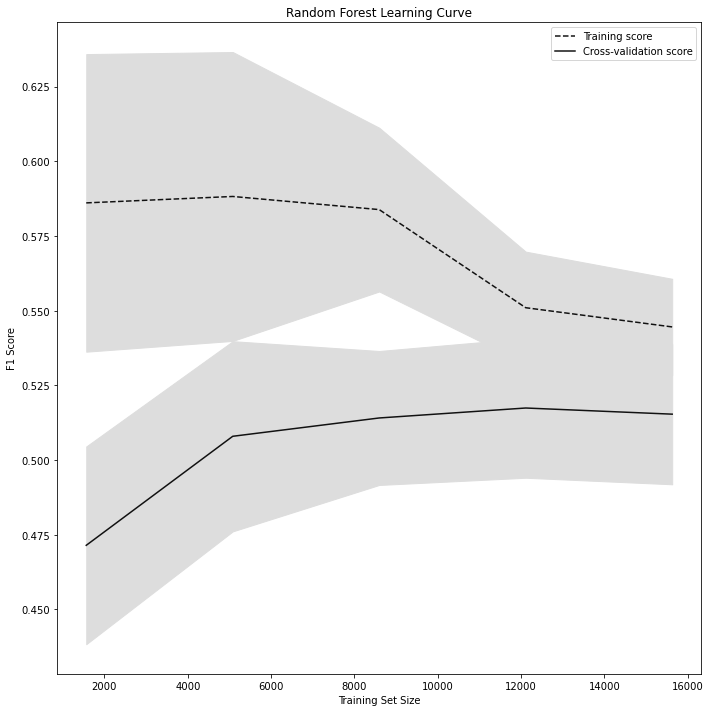

In [45]:
plt.subplots(1, figsize=(10,10))
plt.plot(rf_train_sizes, rf_train_mean, '--', color="#111111",  label="Training score")
plt.plot(rf_train_sizes, rf_test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(rf_train_sizes, rf_train_mean - rf_train_std, rf_train_mean + rf_train_std, color="#DDDDDD")
plt.fill_between(rf_train_sizes, rf_test_mean - rf_test_std, rf_test_mean + rf_test_std, color="#DDDDDD")

plt.title("Random Forest Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("F1 Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### AdaBoost

In [46]:
ada_boost_params = {'n_estimators' : [2, 10, 50],
                    'learning_rate' : [0.1, 0.5, 1],
                    'algorithm' : ['SAMME.R', 'SAMME']
                   }

In [47]:
ada_boost = AdaBoostClassifier()
ada_random = RandomizedSearchCV(estimator = ada_boost, param_distributions=ada_boost_params, cv=9, scoring='f1')
ada_random.fit(X_train_transformed, y_train)
ada_random_best_params = ada_random.best_params_
ada_random_best_score = ada_random.best_score_
ada_random_predictions = ada_random.predict(X_test_transformed)
ada_random_roc_auc = roc_auc_score(y_test, ada_random_predictions)
ada_random_f1 = f1_score(y_test, ada_random_predictions)
ada_random_accuracy = accuracy_score(y_test, ada_random_predictions)
ada_random_confusion_matrix = confusion_matrix(y_test, ada_random_predictions)

In [48]:
tabel_data.append(["Ada Boost", ada_random_roc_auc, ada_random_f1, 
                   ada_random_accuracy, ada_random_best_score, ada_random_confusion_matrix])

In [49]:
ada_random_best_params

{'n_estimators': 50, 'learning_rate': 1, 'algorithm': 'SAMME.R'}

In [50]:
ada_train_sizes, ada_train_scores, ada_test_scores = learning_curve(ada_random, X_train_transformed, y_train, 
                                                        cv=9, scoring='f1')

In [51]:
ada_train_mean = np.mean(ada_train_scores, axis=1)
ada_train_std = np.std(ada_train_scores, axis=1)
ada_test_mean = np.mean(ada_test_scores, axis=1)
ada_test_std = np.std(ada_test_scores, axis=1)

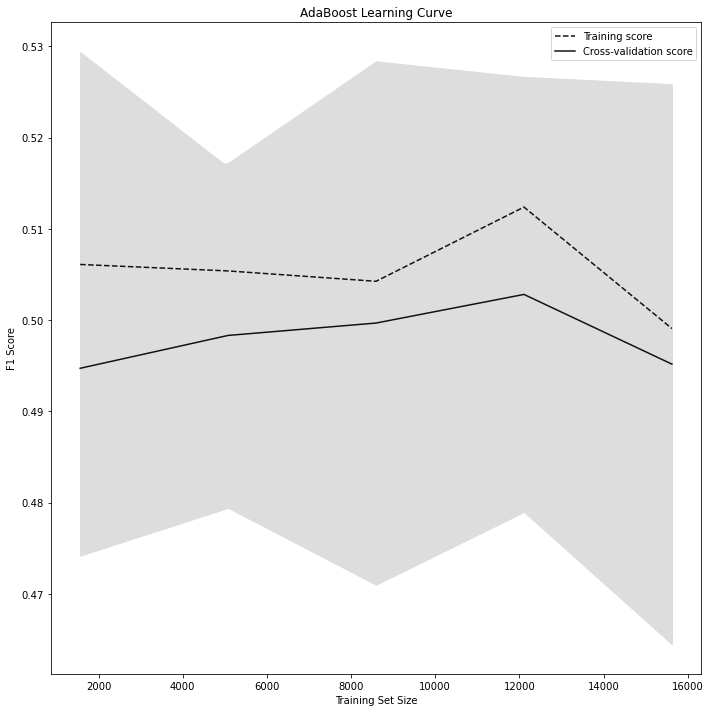

In [52]:
plt.subplots(1, figsize=(10,10))
plt.plot(ada_train_sizes, ada_train_mean, '--', color="#111111",  label="Training score")
plt.plot(ada_train_sizes, ada_test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(ada_train_sizes, ada_train_mean - ada_train_std, ada_train_mean + ada_train_std, color="#DDDDDD")
plt.fill_between(ada_train_sizes, ada_test_mean - ada_test_std, ada_test_mean + ada_test_std, color="#DDDDDD")

plt.title("AdaBoost Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("F1 Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Extra Trees Classifier

In [53]:
extra_tree_clf_params = {'n_estimators' : [2, 10, 50],
                         'criterion' : ['gini', 'entropy'],
                         'max_features': [1, 10, 30, X_train_transformed.shape[1]],
                         'max_depth': [5, 10, 20, None],
                         'bootstrap': [True, False]
                        }

In [54]:
extra_tree_clf = ExtraTreesClassifier()
extra_tree_clf_random = RandomizedSearchCV(estimator = extra_tree_clf, 
                                           param_distributions=extra_tree_clf_params, cv=9, scoring='f1')
extra_tree_clf_random.fit(X_train_transformed, y_train)
extra_tree_clf_random_best_params = ada_random.best_params_
extra_tree_clf_random_best_score = ada_random.best_score_
extra_tree_clf_random_predictions = ada_random.predict(X_test_transformed)
extra_tree_clf_random_roc_auc = roc_auc_score(y_test, extra_tree_clf_random_predictions)
extra_tree_clf_random_f1 = f1_score(y_test, extra_tree_clf_random_predictions)
extra_tree_clf_random_accuracy = accuracy_score(y_test, extra_tree_clf_random_predictions)
extra_tree_clf_random_confusion_matrix = confusion_matrix(y_test, extra_tree_clf_random_predictions)

In [55]:
tabel_data.append(["Extra Tree Classifier", extra_tree_clf_random_roc_auc, 
                   extra_tree_clf_random_f1, extra_tree_clf_random_accuracy, 
                   extra_tree_clf_random_best_score, extra_tree_clf_random_confusion_matrix])

In [56]:
extra_tree_clf_random_best_params

{'n_estimators': 50, 'learning_rate': 1, 'algorithm': 'SAMME.R'}

### Gradient Boosted Trees

In [57]:
gradient_boosting_clf_params = {'loss' : ['deviance', 'exponential'],
                                'learning_rate' : [0.1, 0.5, 1],
                                'n_estimators' : [2, 10, 50],
                                'criterion' : ['squared_error', 'mse', 'mae'],
                                'max_features': [1, 10, 30, X_train_transformed.shape[1]],
                                'max_depth': [5, 10, 20, None]
                               }

In [58]:
gradient_boosting_clf = GradientBoostingClassifier()
gradient_boosting_clf_random = RandomizedSearchCV(estimator = gradient_boosting_clf, 
                                                  param_distributions=gradient_boosting_clf_params, cv=9, 
                                                  scoring='f1')
gradient_boosting_clf_random.fit(X_train_transformed, y_train)
gradient_boosting_clf_random_best_params = ada_random.best_params_
gradient_boosting_clf_best_score = ada_random.best_score_
gradient_boosting_clf_random_predictions = ada_random.predict(X_test_transformed)
gradient_boosting_clf_random_roc_auc = roc_auc_score(y_test, gradient_boosting_clf_random_predictions)
gradient_boosting_clf_random_f1 = f1_score(y_test, gradient_boosting_clf_random_predictions)
gradient_boosting_clf_random_accuracy = accuracy_score(y_test, gradient_boosting_clf_random_predictions)
gradient_boosting_clf_random_confusion_matrix=confusion_matrix(y_test, gradient_boosting_clf_random_predictions)

/Users/Negin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/Negin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/Negin/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 504, in fit
    n_stages = self._fit_stages(
  File "/Users/Negin/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 561, in _fit_stages
    raw_predictions = self._fit_stage(
  File "/Users/Negin/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 214, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "/Users/Negin/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line

/Users/Negin/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Users/Negin/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Users/Negin/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_ms

/Users/Negin/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Users/Negin/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'mse' instead, as trees should use a least-square criterion in Gradient Boosting.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "
/Users/Negin/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1118: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_ms

/Users/Negin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.48623597        nan        nan 0.50188191 0.25856143        nan
 0.14666375 0.49852635        nan 0.38760825]
  warnings.warn(


In [59]:
tabel_data.append(["Gradient Boosted Trees", gradient_boosting_clf_random_roc_auc, 
                   gradient_boosting_clf_random_f1, gradient_boosting_clf_random_accuracy, 
                   gradient_boosting_clf_best_score, gradient_boosting_clf_random_confusion_matrix])

In [60]:
gradient_boosting_clf_random_best_params

{'n_estimators': 50, 'learning_rate': 1, 'algorithm': 'SAMME.R'}

In [61]:
print(tabulate(tabel_data, headers=head, tablefmt="grid"))

+----------------------------+-----------------+------------+------------+--------------+--------------------+
| RandomizedSearchCV Model   |   ROC-AUC Score |   F1 Score |   Accuracy |   Best Score | Confusion Matrix   |
+============================+=================+============+============+==============+====================+
| Decision Tree              |        0.660085 |   0.480406 |   0.807679 |     0.480793 | [[4212  302]       |
|                            |                 |            |            |              |  [ 825  521]]      |
+----------------------------+-----------------+------------+------------+--------------+--------------------+
| Random Forest              |        0.672805 |   0.504854 |   0.817235 |     0.510989 | [[4243  271]       |
|                            |                 |            |            |              |  [ 800  546]]      |
+----------------------------+-----------------+------------+------------+--------------+--------------------+
|

#### Question 4 (3 pts)

Discuss and compare the results for the all past three questions. 

* How does changing hyperparms effect model performance? 
* Why do you think certain models performed better/worse? 
* How does this performance line up with known strengths/weakness of these models?

Changing the hyperparametrs did change the performance of the models but changes were not that huge.

Depending on the way each decision trees is formed, the shape and result of the decision trees could differ a lot. The models that split the input by more important features first, usually have better results. Things like this could change the output of a decision tree a lot.

We know that decision trees can overfit easily, In all of our results, the models predicted zeros better than ones. Since our data is imbalanced and has more zeros, I think all of our models are overfit and the ratio of right-predicted-ones to wrong-predicted-ones is way less than the ratio of right-predicted-zeros to wrong-predicted-zeros.